# Tenor + Alto saxophone SVM analysis

* Sample duration = 5s
* model = SVM
* target = ALTO + Tenor

Distinguish between samples with alto or tenor saxophone from those without alto or tenor saxophone. Other brass and reed instruments excluded.

Gather statistics, plot precision-recall and ROC curves.

In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [2]:
df = pd.read_pickle('./data/5s/labeled/features_r02/all_data.pkl')

In [5]:
fn = './scikit_models/alto_+_tenor_svm_bagging_tuned_c.pkl'
# This is the saved model.
with open(fn, 'rb') as fh:
    model = pickle.load(fh)

In [6]:
NUM_LABEL_COLS = 13
NUM_COMPONENTS = 26
TEST_SIZE = 0.2
RANDOM_SEED = 0

In [7]:
df_filtered = df
df_filtered.shape

(9080, 10790)

In [8]:
# exclude records we want to exclude
df_filtered = df_filtered[df_filtered['sop'] == '0']
df_filtered = df_filtered[df_filtered['bari'] == '0']
df_filtered = df_filtered[df_filtered['clrt'] == '0']
df_filtered = df_filtered[df_filtered['tora'] == '0']
df_filtered = df_filtered[df_filtered['othr'] == '0']
df_filtered = df_filtered[df_filtered['trmp'] == '0']
df_filtered = df_filtered[df_filtered['trmb'] == '0']
df_filtered = df_filtered[df_filtered['otrb'] == '0']

num_x_cols = df_filtered.shape[1] - NUM_LABEL_COLS 
data = df_filtered.iloc[:, 1:num_x_cols].to_numpy() 
# ^ These are the features
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

# Create target column
combined = df_filtered[['tenr']].to_numpy() + df_filtered[['alto']].to_numpy() + df_filtered[['tora']].to_numpy()
combined = combined.astype('int')
combined[combined > 0] = 1
df_filtered['tenor/alto'] = combined

target = df_filtered[['tenor/alto']].to_numpy().ravel()  # << This is the label

print(data.shape)
print(target.shape)

(7325, 10776)
(7325,)


In [9]:
pca = PCA(n_components=NUM_COMPONENTS)

In [10]:
pca.fit(data)

PCA(n_components=26)

In [11]:
d = pca.transform(data)

In [12]:
x_train, x_test, y_train, y_test = \
     train_test_split(d, target, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [13]:
y_pred = model.predict(x_test)

In [14]:
print(model.score(x_test, y_test))

0.8812286689419795


In [15]:
c_matrix = confusion_matrix(y_test, y_pred)
idx = cols = [0, 1]
pd.DataFrame(c_matrix, index=idx, columns=cols)

,0,1
0,481,115
1,59,810


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       596
           1       0.88      0.93      0.90       869

    accuracy                           0.88      1465
   macro avg       0.88      0.87      0.87      1465
weighted avg       0.88      0.88      0.88      1465



In [17]:
probas_pred = model.predict_proba(x_test)

In [18]:
probas_pred.shape

(1465, 2)

In [19]:
y_pred_pos = probas_pred[:, [1]]

In [23]:
## y_true = [1 if x == '1' else 0 for x in y_test]
y_test
y_true = y_test

In [24]:
precision, recall, threshold = precision_recall_curve(y_true, y_pred_pos)

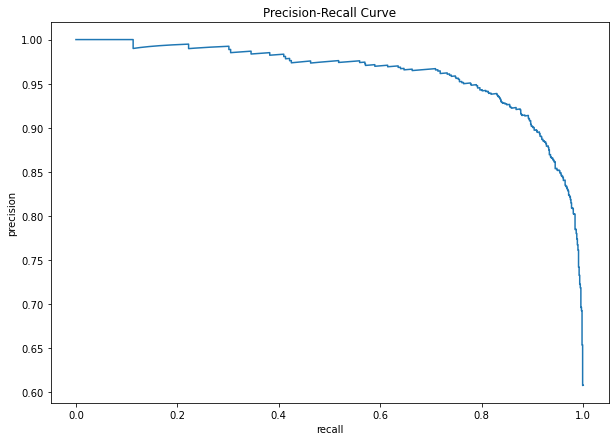

In [25]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("Precision-Recall Curve")
pass

In [26]:
fpr, tpr, threshold = roc_curve(y_true, y_pred_pos)
auc = roc_auc_score(y_true, y_pred_pos)

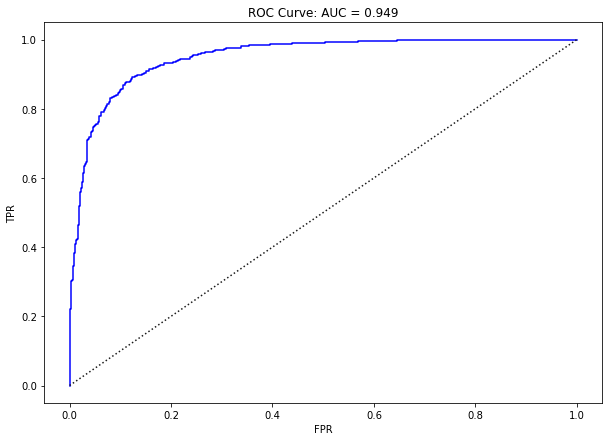

In [27]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1], ':', color='0.1')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve: AUC = {:.3f}".format(auc)) 
pass